# Final Project : Predicting County-Level School Shootings  
### Alex Bass, Connie Cui, Tulsi Ratnam

#### Importing and Scaling the Data

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os
import bambi as bmb

from formulae import design_matrices

In [19]:
data = pd.read_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/train.csv') #reading in final data
data.columns

Index(['STATE', 'gun_own', 'hunt_license', 'background_checks',
       'gun_permit_law', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col', 'population', 'n',
       'gun_strictness', 'rural', 'suburban', 'urban'],
      dtype='object')

In [20]:
data.dropna(inplace = True) #dropping NAs

In [22]:
data['state_r'] = data['STATE']
data = data.replace({'state_r': {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 8: 5, 9: 6, 10: 7, 12: 8, 13: 9, 15: 10, 16: 11, 17: 12, 18: 13, 
                           19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 
                           31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 
                           44: 38, 45: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 53: 46, 54: 47, 55: 48, 56: 49 
}})

state_r = data.state_r.values
n_state = len(data.state_r.unique())

data.state_r.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

#### Poisson regression model with all variables

In [23]:
#scaling all data
columns_to_scale = ['gun_own',
       'hunt_license', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col',
       'population', 'gun_strictness']

data[columns_to_scale] = data[columns_to_scale].apply(lambda x : (x - np.mean(x))/np.std(x))

In [66]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + population + gun_strictness"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  Hispanic  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231 -0.489090   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758 -0.364489   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357 -0.378478   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765 -0.504156   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066 -0.008670   
...        ...       ...       ...       ...       ...       ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  0.448524   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  0.387475   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069 -0.037704   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  0.318928   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853 -0.408079   

      Unemployment_rate_2021  Median_Household_Income_2020   ba_plus  \
0                  -1.054016                      0.694312  0.589642   
1                  -0.940531                      0.939418  0.960109   
2                   0.591523                     -1.276080 -1.134098   
3                  -0.656817                     -0.449379 -1.161714   
4                  -1.280987                     -0.154428 -0.965131   
...                      ...                           ...       ...   
3136                0.534781                      0.901519 -0.143786   
3137               -0.827045                      2.405455  3.348400   
3138                0.194324                      0.947039 -0.361401   
3139               -0.373103                      0.074132  0.124250   
3140               -0.827045                      0.099466 -0.558660   

      less_than_hs        hs  some_col  population  gun_strictness  
0        -0.184500 -0.346835 -0.382626   -0.145751       -1.154567  
1        -0.475586 -0.917436  0.061710    0.355878       -1.154567  
2         2.131007  0.245205 -0.690082   -0.239213       -1.154567  
3         1.112068  1.511475 -1.235287   -0.246082       -1.154567  
4         0.790681  0.158194  0.638844   -0.139885       -1.154567  
...            ...       ...       ...         ...             ...  
3136     -0.823092 -0.224346  1.501087   -0.186291       -2.055884  
3137     -1.173494 -2.484783 -1.319654   -0.242875       -2.055884  
3138     -0.911429  0.505643  0.988468   -0.252580       -2.055884  
3139     -0.729335 -0.699993  1.565122   -0.289808       -2.055884  
3140     -0.949096  0.572114  1.297233   -0.292440       -2.055884  

[3141 rows x 19 columns]

In [67]:
quick_prior_change = 5

with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("background_checks", mu=0, sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("gun_permit_law", mu=0, sigma=quick_prior_change)
    b3 = pm.Normal("under40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment_rate_2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median_Household_Income_2020", mu=0, sigma=quick_prior_change)
    b11 = pm.Normal("ba_plus", mu=0, sigma=quick_prior_change)
    b12 = pm.Normal("less_than_hs", mu=0, sigma=quick_prior_change)
    b13 = pm.Normal("hs", mu=0, sigma=quick_prior_change)
    b14 = pm.Normal("some_col", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("gun_strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("gun_own", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("hunt_license", mu=0, sigma=quick_prior_change)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        + b11 * mx_ex["ba_plus"].values
        + b12 * mx_ex["less_than_hs"].values
        + b13 * mx_ex["hs"].values
        + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [68]:
with mdl_fish:
    inf_fish = pm.sample(1000, tune=1000, target_accept = 0.9, init='adapt_diag')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hunt_license, gun_own, gun_strictness, population, some_col, hs, less_than_hs, ba_plus, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, gun_permit_law, background_checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 728 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


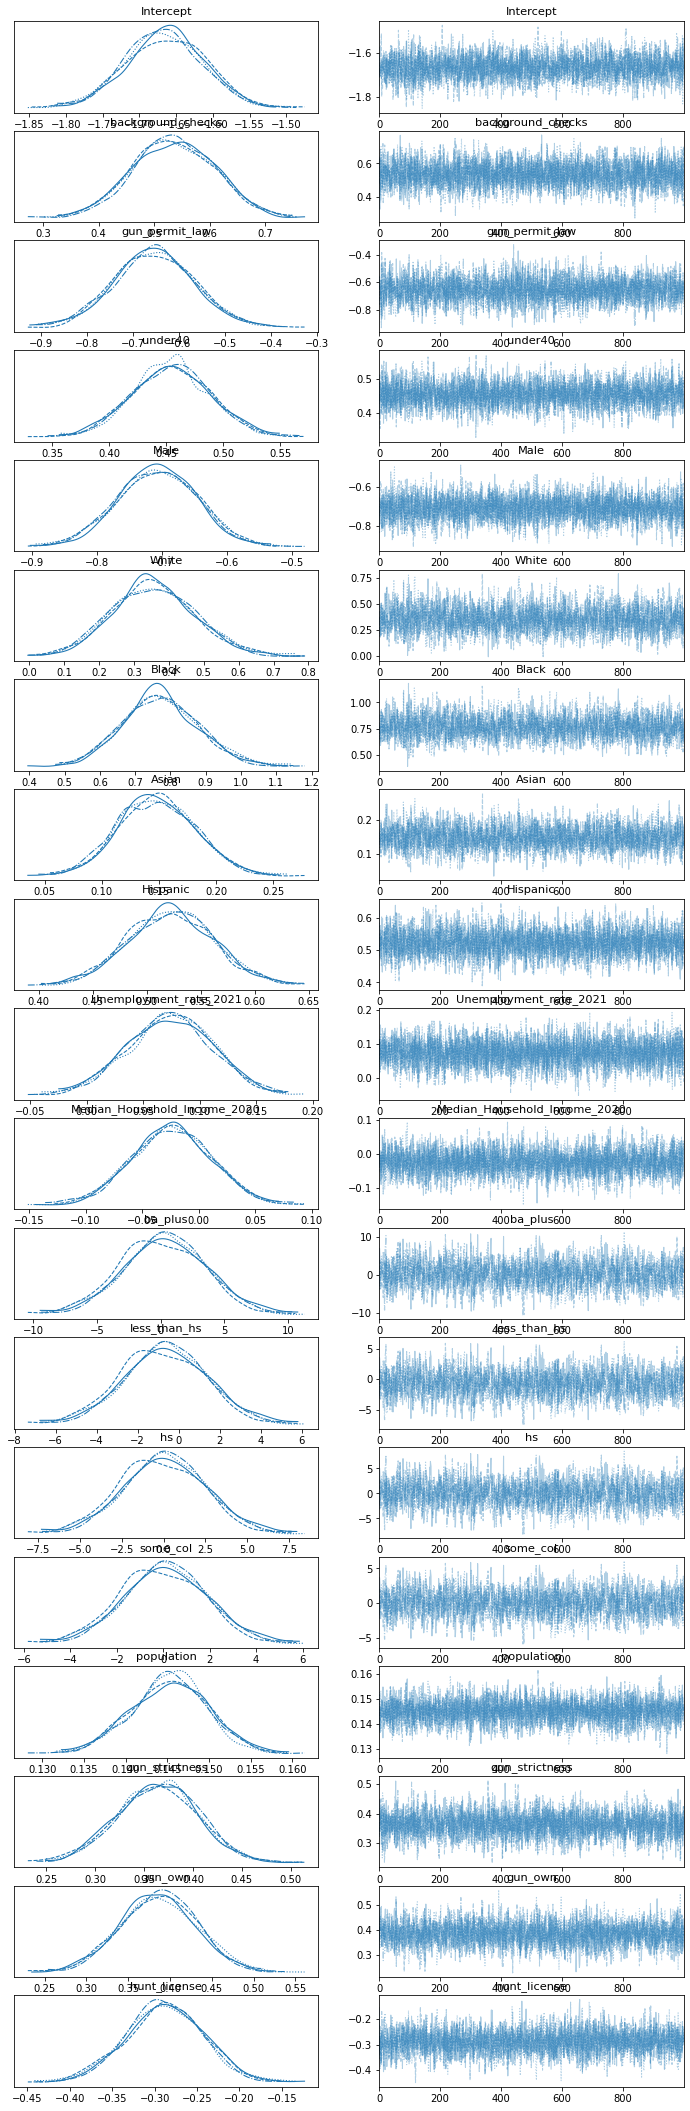

In [69]:
az.plot_trace(inf_fish);

In [70]:
az.summary(inf_fish, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -1.666  0.053  -1.760   -1.565
background_checks             0.536  0.073   0.402    0.675
gun_permit_law               -0.655  0.086  -0.808   -0.485
under40                       0.455  0.034   0.393    0.522
Male                         -0.707  0.061  -0.824   -0.598
White                         0.358  0.120   0.138    0.588
Black                         0.772  0.107   0.574    0.974
Asian                         0.148  0.034   0.084    0.209
Hispanic                      0.523  0.040   0.450    0.601
Unemployment_rate_2021        0.074  0.037   0.002    0.143
Median_Household_Income_2020 -0.024  0.035  -0.086    0.044
ba_plus                       0.299  3.301  -5.686    6.825
less_than_hs                 -0.654  2.058  -4.459    3.365
hs                            0.026  2.511  -4.525    4.984
some_col                      0.063  1.819  -3.255    3.638
population                    0.145  0.005   0.136    0.153
gun_strictness                0.364  0.041   0.287    0.442
gun_own                       0.386  0.046   0.297    0.469
hunt_license                 -0.288  0.046  -0.378   -0.209

#### Poisson Regression Model with Selected Variables

In [71]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + population + gun_strictness"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  Hispanic  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231 -0.489090   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758 -0.364489   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357 -0.378478   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765 -0.504156   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066 -0.008670   
...        ...       ...       ...       ...       ...       ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  0.448524   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  0.387475   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069 -0.037704   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  0.318928   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853 -0.408079   

      Unemployment_rate_2021  Median_Household_Income_2020  population  \
0                  -1.054016                      0.694312   -0.145751   
1                  -0.940531                      0.939418    0.355878   
2                   0.591523                     -1.276080   -0.239213   
3                  -0.656817                     -0.449379   -0.246082   
4                  -1.280987                     -0.154428   -0.139885   
...                      ...                           ...         ...   
3136                0.534781                      0.901519   -0.186291   
3137               -0.827045                      2.405455   -0.242875   
3138                0.194324                      0.947039   -0.252580   
3139               -0.373103                      0.074132   -0.289808   
3140               -0.827045                      0.099466   -0.292440   

      gun_strictness  
0          -1.154567  
1          -1.154567  
2          -1.154567  
3          -1.154567  
4          -1.154567  
...              ...  
3136       -2.055884  
3137       -2.055884  
3138       -2.055884  
3139       -2.055884  
3140       -2.055884  

[3141 rows x 15 columns]

In [72]:
quick_prior_change = 5

with pm.Model() as mdl_fish_2:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("background_checks", mu=0, sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("gun_permit_law", mu=0, sigma=quick_prior_change)
    b3 = pm.Normal("under40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment_rate_2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median_Household_Income_2020", mu=0, sigma=quick_prior_change)
    # b11 = pm.Normal("ba_plus", mu=0, sigma=quick_prior_change)
    # b12 = pm.Normal("less_than_hs", mu=0, sigma=quick_prior_change)
    # b13 = pm.Normal("hs", mu=0, sigma=quick_prior_change)
    # b14 = pm.Normal("some_col", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("gun_strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("gun_own", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("hunt_license", mu=0, sigma=quick_prior_change)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        # + b11 * mx_ex["ba_plus"].values
        # + b12 * mx_ex["less_than_hs"].values
        # + b13 * mx_ex["hs"].values
        # + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [73]:
with mdl_fish_2:
    inf_fish_2 = pm.sample(1000, tune=1000, init='adapt_diag')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hunt_license, gun_own, gun_strictness, population, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, gun_permit_law, background_checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


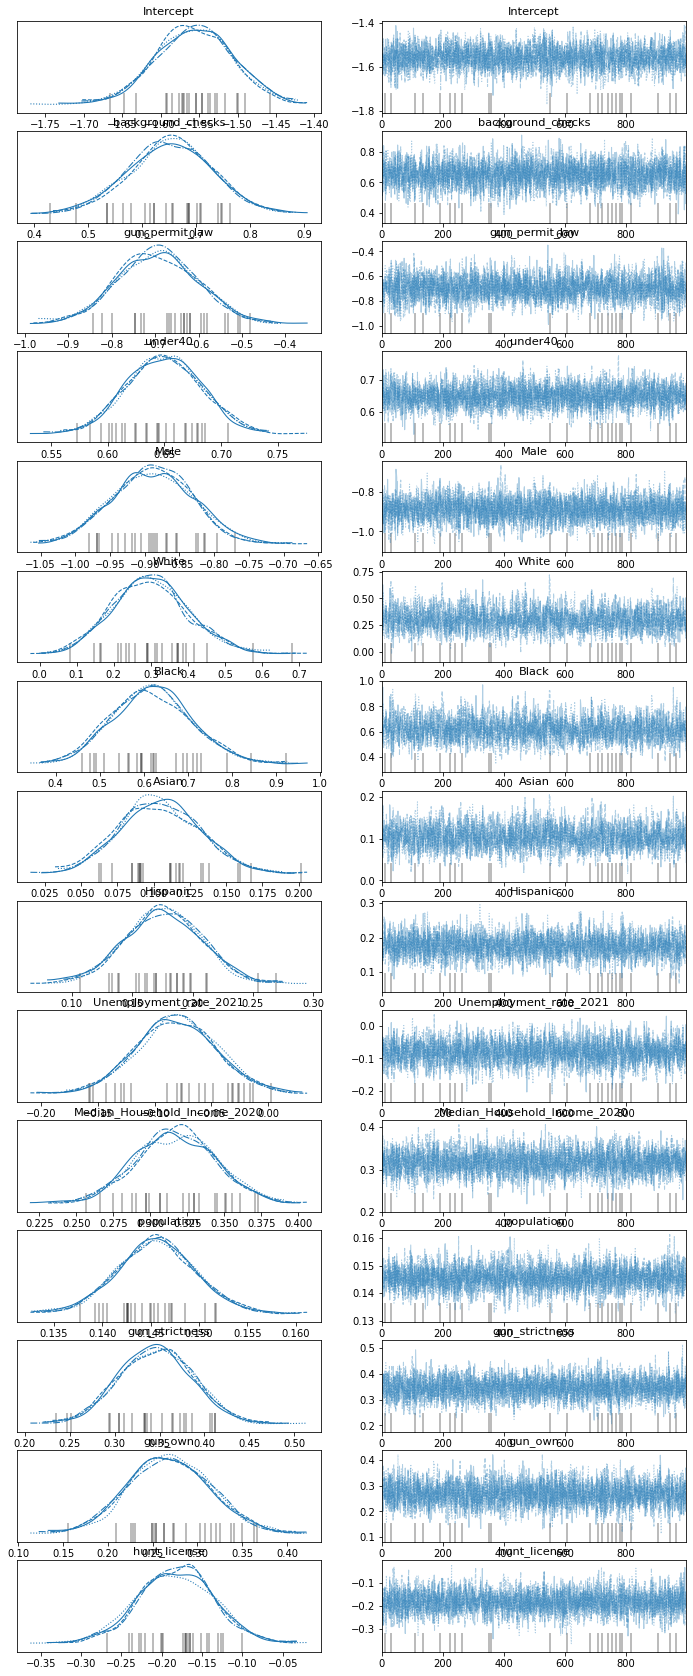

In [74]:
az.plot_trace(inf_fish_2);

In [75]:
az.summary(inf_fish_2, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -1.557  0.050  -1.645   -1.460
background_checks             0.653  0.078   0.510    0.803
gun_permit_law               -0.695  0.093  -0.871   -0.524
under40                       0.649  0.033   0.586    0.708
Male                         -0.889  0.058  -0.998   -0.784
White                         0.300  0.103   0.116    0.501
Black                         0.620  0.090   0.458    0.792
Asian                         0.105  0.028   0.053    0.157
Hispanic                      0.176  0.032   0.114    0.232
Unemployment_rate_2021       -0.081  0.035  -0.145   -0.011
Median_Household_Income_2020  0.317  0.027   0.268    0.369
population                    0.146  0.004   0.138    0.153
gun_strictness                0.346  0.040   0.272    0.421
gun_own                       0.269  0.045   0.185    0.356
hunt_license                 -0.182  0.047  -0.280   -0.102

#### Zero Inflated Poisson Regression with All Variables

In [76]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + population + gun_strictness + rural + suburban + urban"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  ...  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231  ...   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758  ...   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357  ...   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765  ...   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066  ...   
...        ...       ...       ...       ...       ...  ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  ...   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  ...   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069  ...   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  ...   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853  ...   

      Median_Household_Income_2020   ba_plus  less_than_hs        hs  \
0                         0.694312  0.589642     -0.184500 -0.346835   
1                         0.939418  0.960109     -0.475586 -0.917436   
2                        -1.276080 -1.134098      2.131007  0.245205   
3                        -0.449379 -1.161714      1.112068  1.511475   
4                        -0.154428 -0.965131      0.790681  0.158194   
...                            ...       ...           ...       ...   
3136                      0.901519 -0.143786     -0.823092 -0.224346   
3137                      2.405455  3.348400     -1.173494 -2.484783   
3138                      0.947039 -0.361401     -0.911429  0.505643   
3139                      0.074132  0.124250     -0.729335 -0.699993   
3140                      0.099466 -0.558660     -0.949096  0.572114   

      some_col  population  gun_strictness  rural  suburban  urban  
0    -0.382626   -0.145751       -1.154567    0.0       0.0    1.0  
1     0.061710    0.355878       -1.154567    0.0       0.0    1.0  
2    -0.690082   -0.239213       -1.154567    0.0       1.0    0.0  
3    -1.235287   -0.246082       -1.154567    0.0       0.0    1.0  
4     0.638844   -0.139885       -1.154567    0.0       0.0    1.0  
...        ...         ...             ...    ...       ...    ...  
3136  1.501087   -0.186291       -2.055884    0.0       1.0    0.0  
3137 -1.319654   -0.242875       -2.055884    1.0       0.0    0.0  
3138  0.988468   -0.252580       -2.055884    1.0       0.0    0.0  
3139  1.565122   -0.289808       -2.055884    1.0       0.0    0.0  
3140  1.297233   -0.292440       -2.055884    1.0       0.0    0.0  

[3141 rows x 22 columns]

In [85]:
quick_prior_change = 5

with pm.Model() as mdl_fish_3:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("Background Checks", sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("Gun Permit Law", sigma=quick_prior_change)
    b3 = pm.Normal("Under 40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment Rate 2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median Household Income 2020", mu=0, sigma=quick_prior_change)
    b11 = pm.Normal("College Degree", mu=0, sigma=quick_prior_change)
    b12 = pm.Normal("Less than HS", mu=0, sigma=quick_prior_change)
    b13 = pm.Normal("High School Degree", mu=0, sigma=quick_prior_change)
    b14 = pm.Normal("Some College", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("Population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("Gun Law Strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("Gun Ownership", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("Hunting License", mu=0, sigma=quick_prior_change)
    # b19 = pm.Normal("Urban", mu=0, sigma=quick_prior_change)
    # b20 = pm.Normal("Suburban", mu=0, sigma=quick_prior_change)
    # b21 = pm.Normal("Rural", mu=0, sigma=quick_prior_change)

    psi = pm.Beta('psi', 1, 1)
    
    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        + b11 * mx_ex["ba_plus"].values
        + b12 * mx_ex["less_than_hs"].values
        + b13 * mx_ex["hs"].values
        + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
        # + b19 * mx_ex["urban"].values
        # + b20 * mx_ex["suburban"].values
        # + b21 * mx_ex["rural"].values
    )

    ## Define Poisson likelihood
    y = pm.ZeroInflatedPoisson("y", psi = psi, theta=pm.math.exp(theta), observed=mx_en["n"].values)

In [86]:
with mdl_fish_3:
    inf_fish_3 = pm.sample(1000, tune=1000, init="adapt_diag", target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, Hunting License, Gun Ownership, Gun Law Strictness, Population, Some College, High School Degree, Less than HS, College Degree, Median Household Income 2020, Unemployment Rate 2021, Hispanic, Asian, Black, White, Male, Under 40, Gun Permit Law, Background Checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1243 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


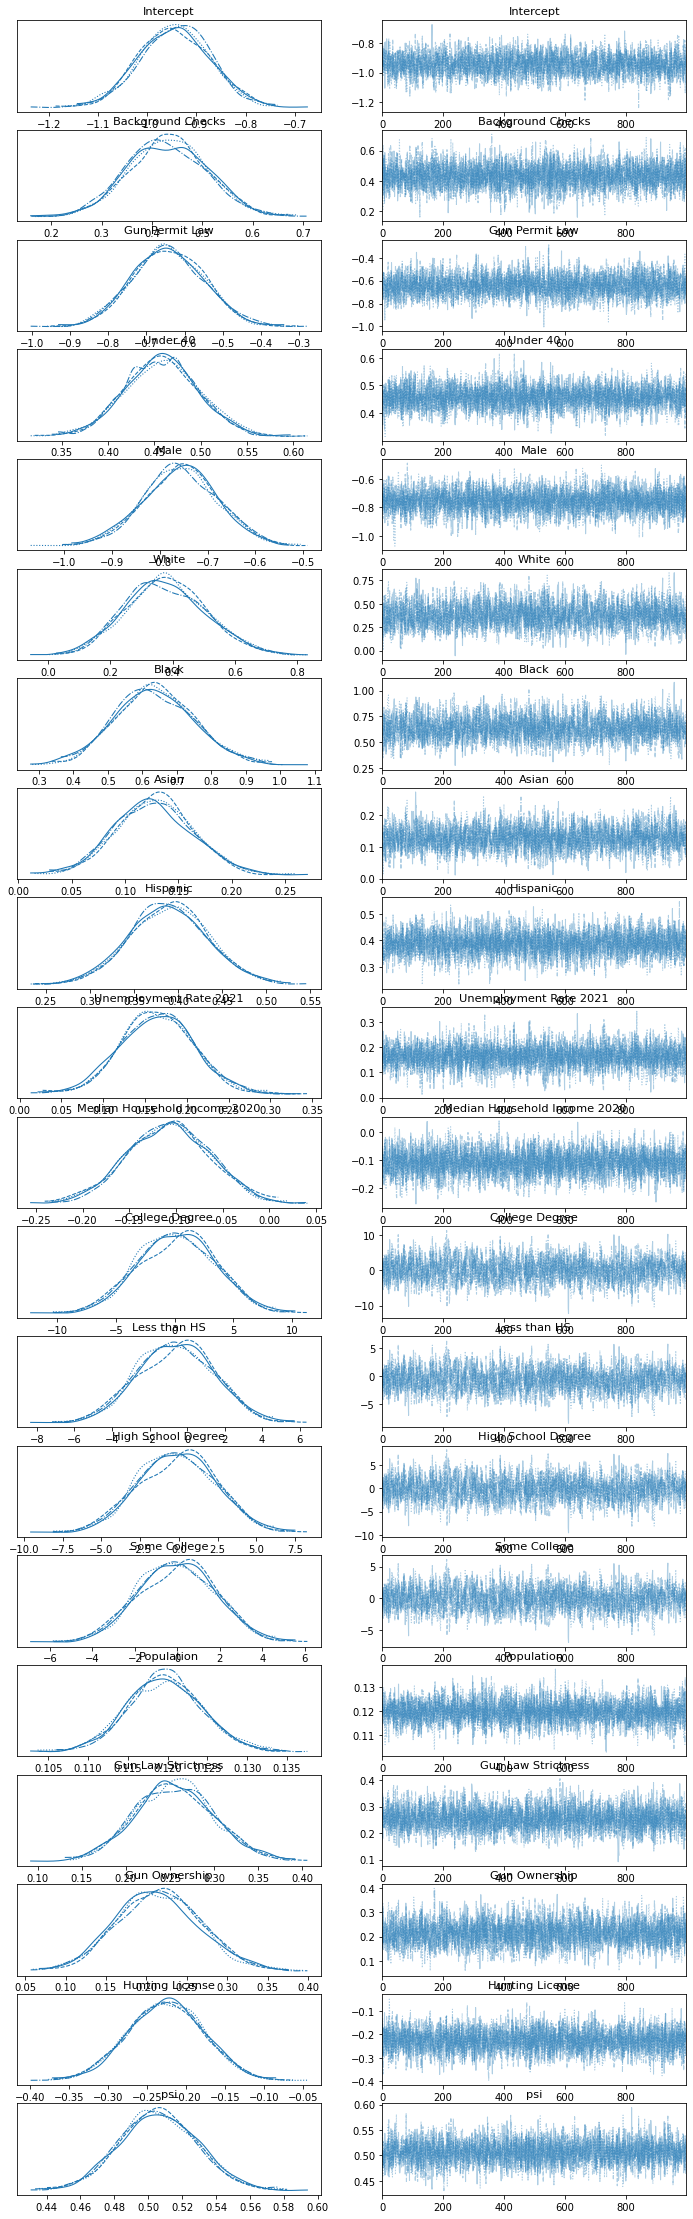

In [87]:
az.plot_trace(inf_fish_3);

In [88]:
az.summary(inf_fish_3, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -0.944  0.071  -1.079   -0.813
Background Checks             0.431  0.079   0.287    0.584
Gun Permit Law               -0.643  0.093  -0.828   -0.481
Under 40                      0.458  0.040   0.387    0.534
Male                         -0.757  0.078  -0.910   -0.613
White                         0.379  0.130   0.151    0.635
Black                         0.638  0.115   0.424    0.857
Asian                         0.127  0.036   0.062    0.197
Hispanic                      0.389  0.044   0.303    0.472
Unemployment Rate 2021        0.165  0.044   0.084    0.248
Median Household Income 2020 -0.108  0.044  -0.190   -0.025
College Degree                0.182  3.270  -5.659    6.298
Less than HS                 -0.608  2.039  -4.293    3.189
High School Degree           -0.119  2.487  -4.624    4.511
Some College                 -0.030  1.803  -3.303    3.293
Population                    0.120  0.005   0.111    0.129
Gun Law Strictness            0.255  0.045   0.170    0.337
Gun Ownership                 0.215  0.051   0.121    0.313
Hunting License              -0.226  0.048  -0.317   -0.136
psi                           0.506  0.023   0.464    0.548

#### Zero Inflated Poisson Regression with Selected Variables

In [89]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Median_Household_Income_2020 + population + gun_strictness"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  Hispanic  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231 -0.489090   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758 -0.364489   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357 -0.378478   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765 -0.504156   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066 -0.008670   
...        ...       ...       ...       ...       ...       ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  0.448524   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  0.387475   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069 -0.037704   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  0.318928   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853 -0.408079   

      Median_Household_Income_2020  population  gun_strictness  
0                         0.694312   -0.145751       -1.154567  
1                         0.939418    0.355878       -1.154567  
2                        -1.276080   -0.239213       -1.154567  
3                        -0.449379   -0.246082       -1.154567  
4                        -0.154428   -0.139885       -1.154567  
...                            ...         ...             ...  
3136                      0.901519   -0.186291       -2.055884  
3137                      2.405455   -0.242875       -2.055884  
3138                      0.947039   -0.252580       -2.055884  
3139                      0.074132   -0.289808       -2.055884  
3140                      0.099466   -0.292440       -2.055884  

[3141 rows x 14 columns]

In [90]:
quick_prior_change = 5

with pm.Model() as mdl_fish_4:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("Background Checks", sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("Gun Permit Law", sigma=quick_prior_change)
    b3 = pm.Normal("Under 40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    #b9 = pm.Normal("Unemployment Rate 2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median Household Income 2020", mu=0, sigma=quick_prior_change)
    #b11 = pm.Normal("College Degree", mu=0, sigma=quick_prior_change)
    #b12 = pm.Normal("Less than HS", mu=0, sigma=quick_prior_change)
    #b13 = pm.Normal("High School Degree", mu=0, sigma=quick_prior_change)
    #b14 = pm.Normal("Some College", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("Population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("Gun Law Strictness", mu=0, sigma=quick_prior_change)
    b17 = pm.Normal("Gun Ownership", mu=0, sigma=quick_prior_change)
    b18 = pm.Normal("Hunting License", mu=0, sigma=quick_prior_change)
    #b19 = pm.Normal("Urban", mu=0, sigma=quick_prior_change)
    #b20 = pm.Normal("Suburban", mu=0, sigma=quick_prior_change)
    #b21 = pm.Normal("Rural", mu=0, sigma=quick_prior_change)

    psi = pm.Beta('psi', 1, 1)
    
    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        #+ b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        #+ b11 * mx_ex["ba_plus"].values
        #+ b12 * mx_ex["less_than_hs"].values
        #+ b13 * mx_ex["hs"].values
        #+ b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        + b17 * mx_ex["gun_own"].values
        + b18 * mx_ex["hunt_license"].values
        #+ b19 * mx_ex["urban"].values
        #+ b20 * mx_ex["suburban"].values
        #+ b21 * mx_ex["rural"].values
    )

    ## Define Poisson likelihood
    y = pm.ZeroInflatedPoisson("y", psi = psi, theta=pm.math.exp(theta), observed=mx_en["n"].values)

In [91]:
with mdl_fish_4:
    inf_fish_4 = pm.sample(1000, tune=1000, init="adapt_diag")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, Hunting License, Gun Ownership, Gun Law Strictness, Population, Median Household Income 2020, Hispanic, Asian, Black, White, Male, Under 40, Gun Permit Law, Background Checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


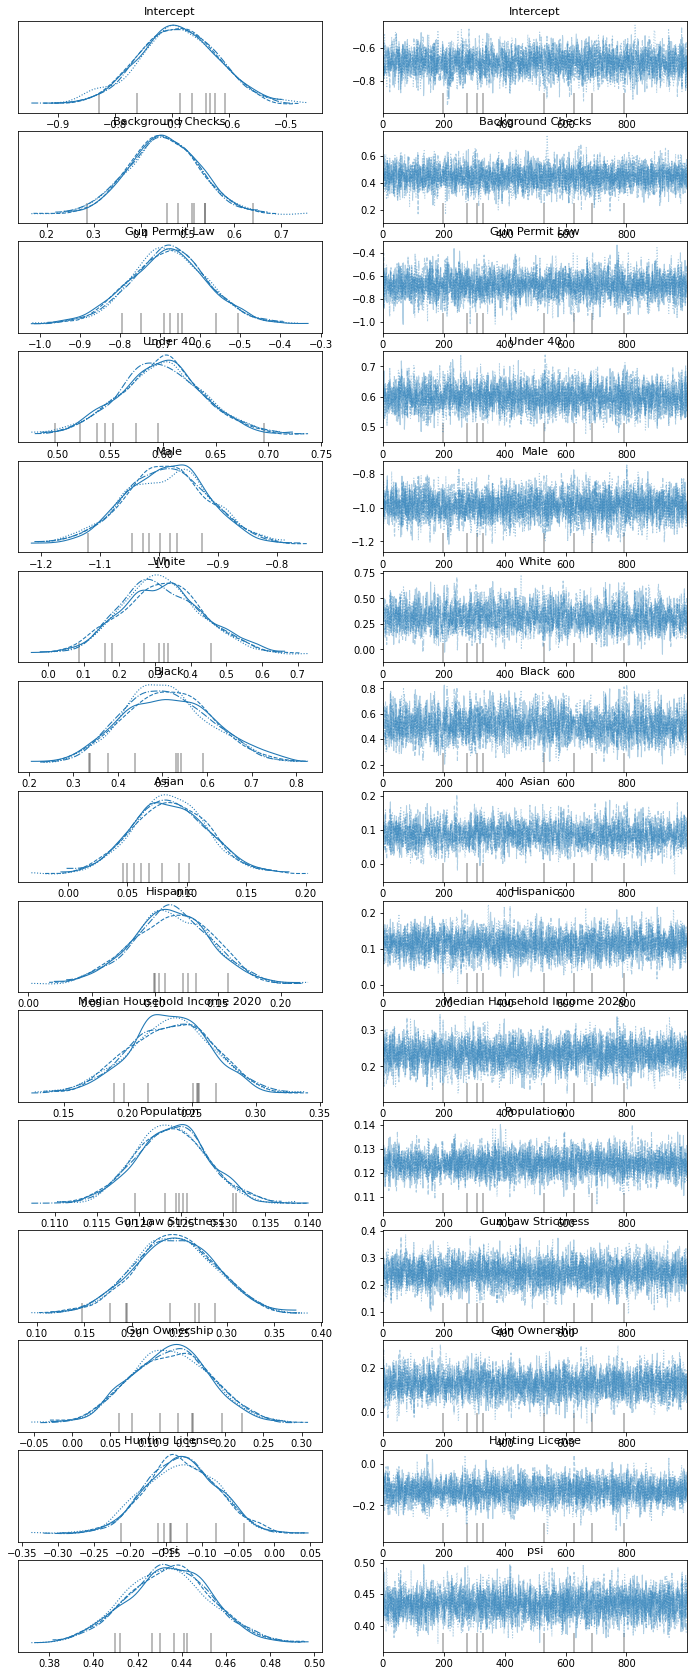

In [92]:
az.plot_trace(inf_fish_4);

In [93]:
az.summary(inf_fish_4, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
Intercept                    -0.690  0.070  -0.825   -0.561
Background Checks             0.449  0.075   0.310    0.591
Gun Permit Law               -0.680  0.098  -0.864   -0.494
Under 40                      0.598  0.039   0.527    0.676
Male                         -0.987  0.072  -1.122   -0.849
White                         0.318  0.116   0.103    0.537
Black                         0.512  0.102   0.330    0.710
Asian                         0.086  0.031   0.026    0.143
Hispanic                      0.114  0.031   0.054    0.171
Median Household Income 2020  0.234  0.033   0.169    0.291
Population                    0.124  0.004   0.116    0.132
Gun Law Strictness            0.245  0.043   0.162    0.322
Gun Ownership                 0.129  0.053   0.030    0.225
Hunting License              -0.129  0.050  -0.224   -0.042
psi                           0.434  0.019   0.397    0.470

#### Hierarchical Poisson All Variables

In [44]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + population + gun_strictness + state_r"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

Intercept   gun_own  hunt_license  background_checks  gun_permit_law  \
0           1.0  0.833042     -0.186645                0.0             0.0   
1           1.0  0.833042     -0.186645                0.0             0.0   
2           1.0  0.833042     -0.186645                0.0             0.0   
3           1.0  0.833042     -0.186645                0.0             0.0   
4           1.0  0.833042     -0.186645                0.0             0.0   
...         ...       ...           ...                ...             ...   
3136        1.0  2.206241      1.079379                0.0             0.0   
3137        1.0  2.206241      1.079379                0.0             0.0   
3138        1.0  2.206241      1.079379                0.0             0.0   
3139        1.0  2.206241      1.079379                0.0             0.0   
3140        1.0  2.206241      1.079379                0.0             0.0   

       under40      Male     White     Black     Asian  Hispanic  \
0     0.397307 -0.717680 -0.495257  0.745100 -0.136231 -0.489090   
1    -0.419029 -0.718403  0.187723 -0.039755 -0.172758 -0.364489   
2     0.204220  1.238609 -2.151528  2.691732 -0.374357 -0.378478   
3     0.386655  1.392354 -0.464478  0.825132 -0.460765 -0.504156   
4     0.074468 -0.388431  0.699984 -0.530321 -0.425066 -0.008670   
...        ...       ...       ...       ...       ...       ...   
3136  1.234813  0.612461  0.573391 -0.549638 -0.171511  0.448524   
3137  0.661028  0.720313  0.648044 -0.596664  0.035955  0.387475   
3138  0.884406  0.190871  0.668374 -0.595385 -0.366069 -0.037704   
3139 -0.643928  0.290855  0.620004 -0.608385 -0.255988  0.318928   
3140 -0.401443  0.971951  0.537848 -0.599440  0.037853 -0.408079   

      Unemployment_rate_2021  Median_Household_Income_2020   ba_plus  \
0                  -1.054016                      0.694312  0.589642   
1                  -0.940531                      0.939418  0.960109   
2                   0.591523                     -1.276080 -1.134098   
3                  -0.656817                     -0.449379 -1.161714   
4                  -1.280987                     -0.154428 -0.965131   
...                      ...                           ...       ...   
3136                0.534781                      0.901519 -0.143786   
3137               -0.827045                      2.405455  3.348400   
3138                0.194324                      0.947039 -0.361401   
3139               -0.373103                      0.074132  0.124250   
3140               -0.827045                      0.099466 -0.558660   

      less_than_hs        hs  some_col  population  gun_strictness  state_r  
0        -0.184500 -0.346835 -0.382626   -0.145751       -1.154567      0.0  
1        -0.475586 -0.917436  0.061710    0.355878       -1.154567      0.0  
2         2.131007  0.245205 -0.690082   -0.239213       -1.154567      0.0  
3         1.112068  1.511475 -1.235287   -0.246082       -1.154567      0.0  
4         0.790681  0.158194  0.638844   -0.139885       -1.154567      0.0  
...            ...       ...       ...         ...             ...      ...  
3136     -0.823092 -0.224346  1.501087   -0.186291       -2.055884     49.0  
3137     -1.173494 -2.484783 -1.319654   -0.242875       -2.055884     49.0  
3138     -0.911429  0.505643  0.988468   -0.252580       -2.055884     49.0  
3139     -0.729335 -0.699993  1.565122   -0.289808       -2.055884     49.0  
3140     -0.949096  0.572114  1.297233   -0.292440       -2.055884     49.0  

[3141 rows x 20 columns]

In [46]:
#full vars
mu_sd = 10
sd_priors = 10
with pm.Model() as h3_model:
# Priors   
    
    # b0 - intercept 
    mu_b0 = pm.Normal('mu_b0', mu=0., sd=mu_sd)
    sigma_b0 = pm.HalfCauchy('sigma_b0', 5)
    
    # Random intercepts as offsets
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_state)
    b0 = pm.Deterministic("a", mu_b0 + a_offset * sigma_b0)

    # Non-hierarchical priors for parameters
    # b5 - hunting license
    b1 = pm.Normal('gun_own', mu=0, sd=sd_priors)
    # b6 - under40
    b2 = pm.Normal('background_checks', mu=0, sd=sd_priors)
    # b7 - male
    b3 = pm.Normal('gun_permit_law', mu=0, sd=sd_priors)
    # b8 - white
    b4 = pm.Normal('gun_strictness', mu=0, sd=sd_priors)
    
    
    # b5 - hunting license
    b5 = pm.Normal('hunt_license', mu=0, sd=sd_priors)
    # b6 - under40
    b6 = pm.Normal('under40', mu=0, sd=sd_priors)
    # b7 - male
    b7 = pm.Normal('Male', mu=0, sd=sd_priors)
    # b8 - white
    b8 = pm.Normal('White', mu=0, sd=sd_priors)
    # b9 - black
    b9 = pm.Normal('Black', mu=0, sd=sd_priors)
    # b10 - asian
    b10 = pm.Normal('Asian', mu=0, sd=sd_priors)
    # b11 - hispanic
    b11 = pm.Normal('Hispanic', mu=0, sd=sd_priors)
    # b12 - unemployment_rate
    b12 = pm.Normal('Unemployment_rate_2021', mu=0, sd=sd_priors)
    # b13 - median_hhi
    b13 = pm.Normal('Median_Household_Income_2020', mu=0, sd=sd_priors)
    # b14 - ba_plus
    b14 = pm.Normal('ba_plus', mu=0, sd=sd_priors)
    # b15 - less_than_hs
    b15 = pm.Normal('less_than_hs', mu=0, sd=sd_priors)
    # b16 - hs
    b16 = pm.Normal('hs', mu=0, sd=sd_priors)
    # b17 - some_col
    b17 = pm.Normal('some_col', mu=0, sd=sd_priors)

    b21 = pm.Normal('population', mu=0, sd=sd_priors)
    
    
    # define linear model and exp link function
    theta = (
        b0[state_r]
        + b1[state_r] * mx_ex["gun_own"].values
        + b2[state_r] * mx_ex["background_checks"].values
        + b3[state_r] * mx_ex["gun_permit_law"].values
        + b4 * mx_ex["gun_strictness"].values
        + b5 * mx_ex["hunt_license"].values
        + b6 * mx_ex["under40"].values
        + b7 * mx_ex["Male"].values
        + b8 * mx_ex["White"].values
        + b9 * mx_ex["Black"].values
        + b10 * mx_ex["Asian"].values
        + b11 * mx_ex["Hispanic"].values
        + b12 * mx_ex["Unemployment_rate_2021"].values
        + b13 * mx_ex["Median_Household_Income_2020"].values
        + b14 * mx_ex["ba_plus"].values
        + b15 * mx_ex["less_than_hs"].values
        + b16 * mx_ex["hs"].values
        + b17 * mx_ex["some_col"].values
        # + b18 * mx_ex["urban"].values
        # + b19 * mx_ex["suburban"].values
        # + b20 * mx_ex["rural"].values
        + b21 * mx_ex["population"].values
    )
    
    # Data likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [47]:
with h3_model:
    step = pm.NUTS(target_accept=0.90)
    h3_trace = pm.sample(1000, tune=1000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [population, some_col, hs, less_than_hs, ba_plus, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, hunt_license, gun_strictness, gun_permit_law, background_checks, gun_own, a_offset, sigma_b0, mu_b0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 957 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


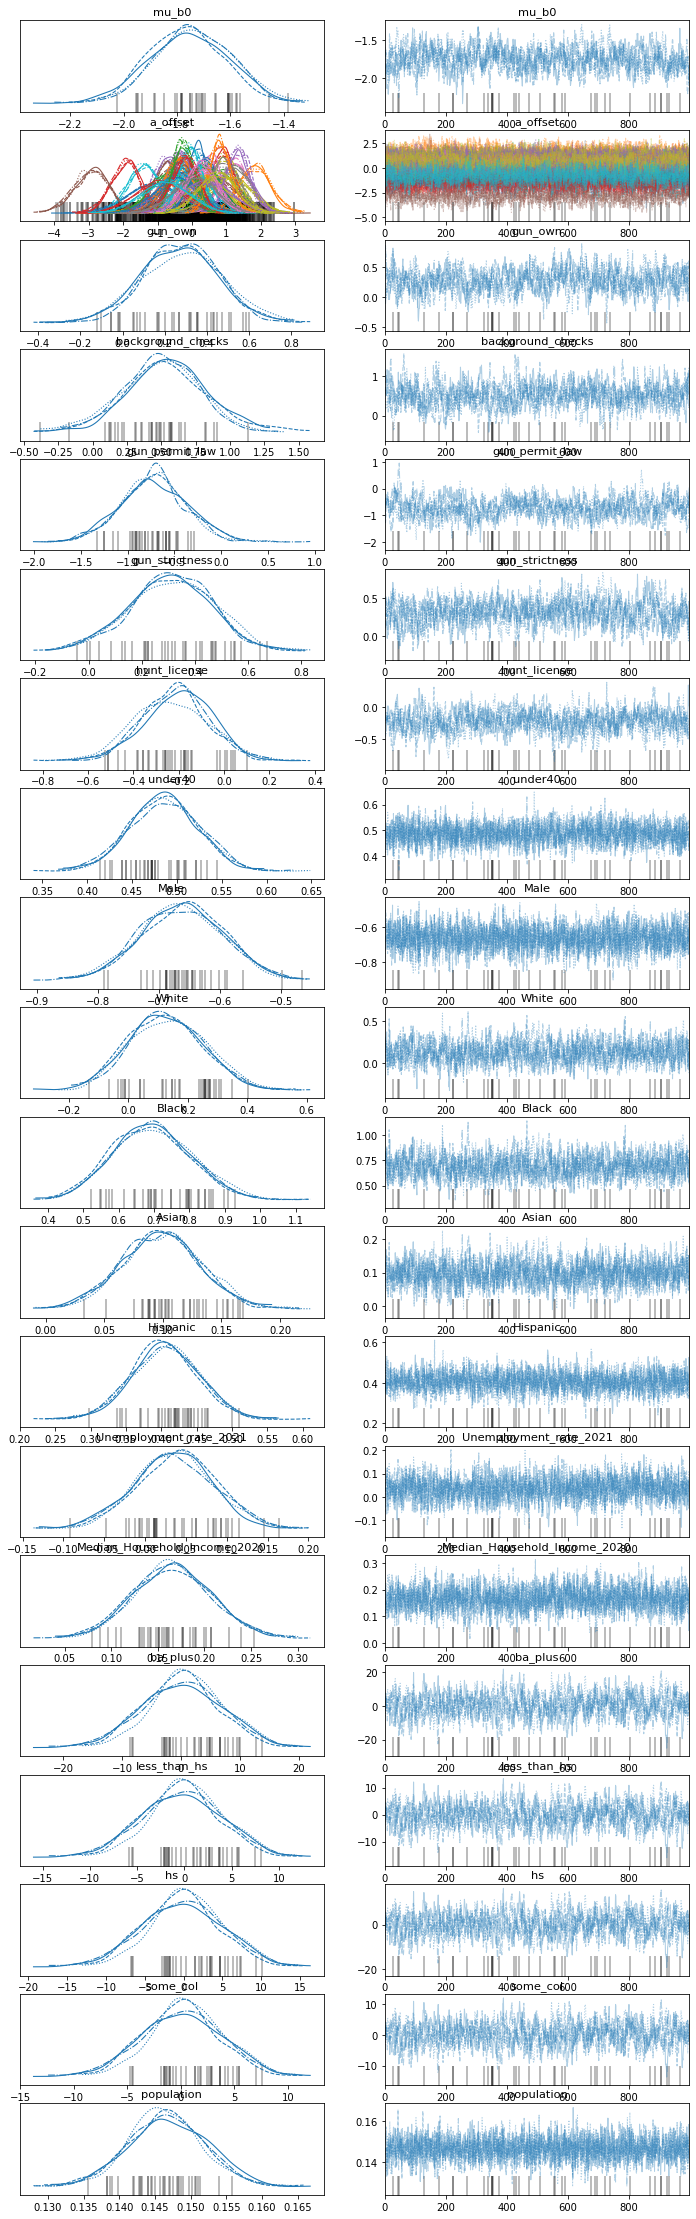

In [48]:
az.plot_trace(h3_trace);

In [39]:
az.summary(h3_trace) # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b0        -0.616  1.323  -2.901    1.918      0.612    0.463       5.0   
Intercept[0] -0.560  1.351  -3.015    2.028      0.614    0.463       5.0   
Intercept[1] -0.748  1.397  -3.425    1.761      0.606    0.455       6.0   
Intercept[2] -0.182  1.349  -2.724    2.323      0.611    0.461       5.0   
Intercept[3] -0.841  1.376  -3.384    1.777      0.627    0.473       5.0   
...             ...    ...     ...      ...        ...      ...       ...   
sigma_b0      0.573  0.118   0.339    0.798      0.027    0.019      20.0   
sigma_b1      0.161  0.168   0.002    0.506      0.057    0.042       7.0   
sigma_b2      0.195  0.172   0.004    0.526      0.061    0.045       7.0   
sigma_b3      0.377  0.271   0.021    0.871      0.086    0.062      10.0   
sigma_b4      0.152  0.120   0.011    0.400      0.033    0.024      13.0   

              ess_tail  r_hat  
mu_b0             11.0   2.24  
Intercept[0]      11.0   2.16  
Intercept[1]      11.0   1.92  
Intercept[2]      11.0   2.02  
Intercept[3]      11.0   2.23  
...                ...    ...  
sigma_b0          32.0   1.13  
sigma_b1          26.0   1.52  
sigma_b2          13.0   1.52  
sigma_b3          75.0   1.34  
sigma_b4          60.0   1.25  

[277 rows x 9 columns]

#### Zero Inflated Heirarchical

In [53]:
#full vars
mu_sd = 10
sd_priors = 10
with pm.Model() as h4_model:
# Priors   
    
    # b0 - intercept 
    mu_b0 = pm.Normal('mu_b0', mu=0., sd=mu_sd)
    sigma_b0 = pm.HalfCauchy('sigma_b0', 5)
    
    # Random intercepts as offsets
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_state)
    b0 = pm.Deterministic("a", mu_b0 + a_offset * sigma_b0)
    
#     # b1 - gun_own 
#     mu_b1 = pm.Normal('mu_b1', mu=0., sd=mu_sd)
#     sigma_b1 = pm.HalfCauchy('sigma_b1', 5)
#     b1 = pm.Normal('gun_own', mu=mu_b1, sd=sigma_b1, shape=n_state)

#     # b2 - background checks 
#     mu_b2 = pm.Normal('mu_b2', mu=0., sd=mu_sd)
#     sigma_b2 = pm.HalfCauchy('sigma_b2', 5)
#     b2 = pm.Normal('background_checks',mu=mu_b2, sd=sigma_b2, shape=n_state)

#     # b3 - gun permit law 
#     mu_b3 = pm.Normal('mu_b3', mu=0., sd=mu_sd)
#     sigma_b3 = pm.HalfCauchy('sigma_b3', 5)
#     b3 = pm.Normal('gun_permit_law', mu=mu_b3, sd=sigma_b3, shape=n_state)
    
#     # b4 - gun strictness 
#     mu_b4 = pm.Normal('mu_b4', mu=0., sd=mu_sd)
#     sigma_b4 = pm.HalfCauchy('sigma_b4', 5)
#     b4 = pm.Normal('gun_strictness', mu=mu_b4, sd=sigma_b4, shape=n_state)

    # Non-hierarchical priors for parameters
    # b5 - hunting license
    b1 = pm.Normal('gun_own', mu=0, sd=sd_priors)
    # b6 - under40
    b2 = pm.Normal('background_checks', mu=0, sd=sd_priors)
    # b7 - male
    b3 = pm.Normal('gun_permit_law', mu=0, sd=sd_priors)
    # b8 - white
    b4 = pm.Normal('gun_strictness', mu=0, sd=sd_priors)
    
    
    # b5 - hunting license
    b5 = pm.Normal('hunt_license', mu=0, sd=sd_priors)
    # b6 - under40
    b6 = pm.Normal('under40', mu=0, sd=sd_priors)
    # b7 - male
    b7 = pm.Normal('Male', mu=0, sd=sd_priors)
    # b8 - white
    b8 = pm.Normal('White', mu=0, sd=sd_priors)
    # b9 - black
    b9 = pm.Normal('Black', mu=0, sd=sd_priors)
    # b10 - asian
    b10 = pm.Normal('Asian', mu=0, sd=sd_priors)
    # b11 - hispanic
    b11 = pm.Normal('Hispanic', mu=0, sd=sd_priors)
    # b12 - unemployment_rate
    b12 = pm.Normal('Unemployment_rate_2021', mu=0, sd=sd_priors)
    # b13 - median_hhi
    b13 = pm.Normal('Median_Household_Income_2020', mu=0, sd=sd_priors)
    # b14 - ba_plus
    b14 = pm.Normal('ba_plus', mu=0, sd=sd_priors)
    # b15 - less_than_hs
    b15 = pm.Normal('less_than_hs', mu=0, sd=sd_priors)
    # b16 - hs
    b16 = pm.Normal('hs', mu=0, sd=sd_priors)
    # b17 - some_col
    b17 = pm.Normal('some_col', mu=0, sd=sd_priors)
    # b18 - urban
    # b18 = pm.Normal('urban', mu=0, sd=sd_priors)
    # # b19 - suburban
    # b19 = pm.Normal('suburban', mu=0, sd=sd_priors)
    # # b20 - rural
    # b20 = pm.Normal('rural', mu=0, sd=sd_priors)
    # b21 - population
    b21 = pm.Normal('population', mu=0, sd=sd_priors)
    
    
    # define linear model and exp link function
    theta = (
        b0[state_r]
        + b1 * mx_ex["gun_own"].values
        + b2 * mx_ex["background_checks"].values
        + b3 * mx_ex["gun_permit_law"].values
        + b4 * mx_ex["gun_strictness"].values
        + b5 * mx_ex["hunt_license"].values
        + b6 * mx_ex["under40"].values
        + b7 * mx_ex["Male"].values
        + b8 * mx_ex["White"].values
        + b9 * mx_ex["Black"].values
        + b10 * mx_ex["Asian"].values
        + b11 * mx_ex["Hispanic"].values
        + b12 * mx_ex["Unemployment_rate_2021"].values
        + b13 * mx_ex["Median_Household_Income_2020"].values
        + b14 * mx_ex["ba_plus"].values
        + b15 * mx_ex["less_than_hs"].values
        + b16 * mx_ex["hs"].values
        + b17 * mx_ex["some_col"].values
        # + b18 * mx_ex["urban"].values
        # + b19 * mx_ex["suburban"].values
        # + b20 * mx_ex["rural"].values
        + b21 * mx_ex["population"].values
    )
    
    psi = pm.Beta('psi', 1, 1)
    
    # Data likelihood
    y = pm.ZeroInflatedPoisson("y", psi = psi, theta=pm.math.exp(theta), observed=mx_en["n"].values)

In [63]:
with h4_model:
    step = pm.NUTS(target_accept=0.9)
    h4_trace = pm.sample(1000, tune=3000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, population, some_col, hs, less_than_hs, ba_plus, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, hunt_license, gun_strictness, gun_permit_law, background_checks, gun_own, a_offset, sigma_b0, mu_b0]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 3385 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


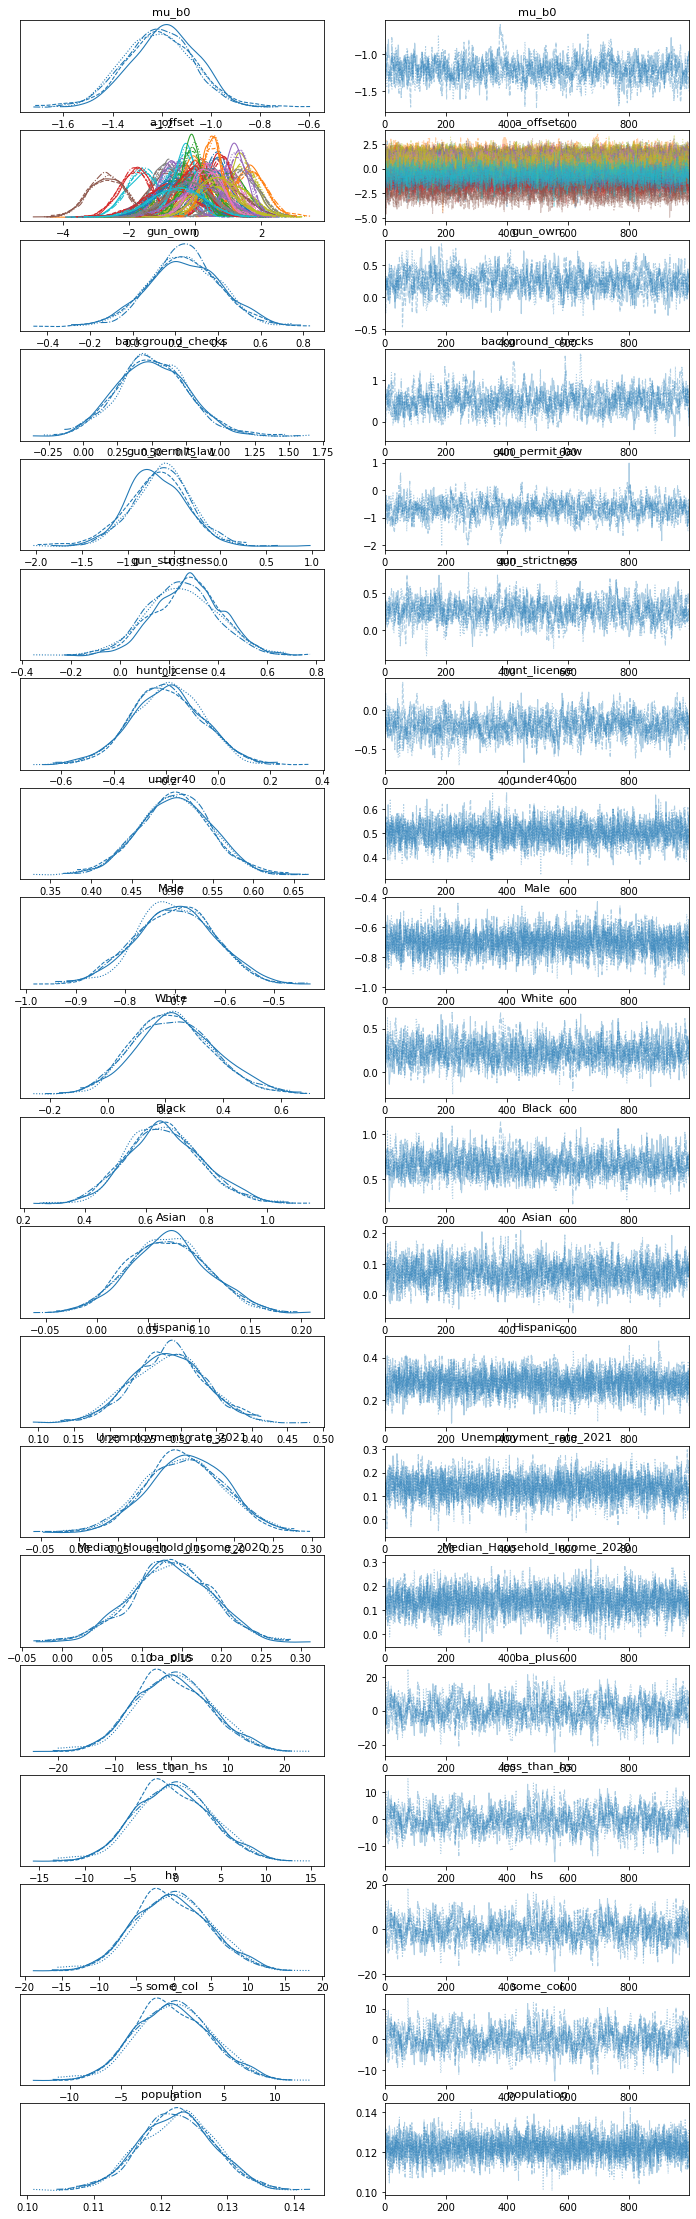

In [64]:
az.plot_trace(h4_trace);

In [94]:
df_comp_loo = az.compare({"pooled_all": inf_fish, 
                          "pooled_selected": inf_fish_2, 
                          'pooled_zero_inflated_all':inf_fish_3, 
                          'pooled_zero_inflated_selected':inf_fish_4, 
                          'heirarchical_poisson':h3_trace,
                          'heirarchical_zero_inflated':h4_trace
                         })
df_comp_loo

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Got error No model on context stack. trying to find log

rank          loo       p_loo       d_loo  \
heirarchical_zero_inflated        0 -2225.573280  157.060659    0.000000   
pooled_zero_inflated_all          1 -2337.220527   80.242197  111.647247   
heirarchical_poisson              2 -2428.352785  196.183776  202.779505   
pooled_zero_inflated_selected     3 -2450.220935   78.026997  224.647656   
pooled_all                        4 -2640.131213  103.946605  414.557933   
pooled_selected                   5 -2816.587878  102.496695  591.014598   

                                     weight          se        dse  warning  \
heirarchical_zero_inflated     4.737757e-01  161.098970   0.000000     True   
pooled_zero_inflated_all       1.727807e-01  187.177762  39.590988     True   
heirarchical_poisson           2.429195e-01  182.250195  42.404933     True   
pooled_zero_inflated_selected  6.276121e-02  179.594327  42.282797     True   
pooled_all                     6.195499e-15  222.966946  79.446732     True   
pooled_selected                4.776295e-02  225.085549  89.752794     True   

                              loo_scale  
heirarchical_zero_inflated          log  
pooled_zero_inflated_all            log  
heirarchical_poisson                log  
pooled_zero_inflated_selected       log  
pooled_all                          log  
pooled_selected                     log

#### A few facts using our best model (I got all the information in these bullet points in the tables below)

 - A theme across all our models and seen in this one as well. Percent educated in a county seems unrelated to gun violence.
 - In our final model, the highest coefficient predicting gun voilence was an increase in the standard deviation of black people living in a county.
 - Interesting difference between background checks and gun permit laws. Compared to their reference classes, places with background checks seem to have more gun violence while places with gun permit laws seem to see less school gun violence.
 - 3 States with most violence: Nevada, Florida, Michigan
 - 3 with the least violence: Virginia, Mississippi, Maryland

In [110]:
tbl = az.summary(h4_trace)[51:70]
tbl

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
gun_own                       0.243  0.168  -0.067    0.563      0.007   
background_checks             0.509  0.258   0.031    0.997      0.011   
gun_permit_law               -0.662  0.322  -1.274   -0.062      0.014   
gun_strictness                0.262  0.143  -0.013    0.522      0.005   
hunt_license                 -0.196  0.139  -0.460    0.058      0.006   
under40                       0.504  0.044   0.425    0.590      0.001   
Male                         -0.699  0.078  -0.852   -0.559      0.001   
White                         0.229  0.136  -0.029    0.478      0.004   
Black                         0.663  0.122   0.443    0.902      0.004   
Asian                         0.070  0.039   0.001    0.146      0.001   
Hispanic                      0.282  0.051   0.189    0.382      0.001   
Unemployment_rate_2021        0.136  0.051   0.045    0.235      0.001   
Median_Household_Income_2020  0.137  0.051   0.042    0.230      0.001   
ba_plus                       0.236  6.648 -11.712   13.213      0.250   
less_than_hs                 -0.230  4.142  -7.764    7.758      0.156   
hs                           -0.155  5.057  -9.200    9.727      0.190   
some_col                      0.060  3.664  -6.610    7.144      0.138   
population                    0.122  0.006   0.111    0.132      0.000   
sigma_b0                      0.625  0.088   0.471    0.793      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
gun_own                         0.005     547.0    1184.0   1.01  
background_checks               0.008     520.0    1061.0   1.00  
gun_permit_law                  0.010     562.0     961.0   1.01  
gun_strictness                  0.004     678.0    1262.0   1.01  
hunt_license                    0.004     580.0    1522.0   1.01  
under40                         0.001    2429.0    2890.0   1.00  
Male                            0.001    2794.0    2793.0   1.00  
White                           0.003    1106.0    1792.0   1.00  
Black                           0.003    1088.0    1887.0   1.00  
Asian                           0.001    1475.0    2391.0   1.00  
Hispanic                        0.001    2750.0    2981.0   1.00  
Unemployment_rate_2021          0.001    2395.0    2386.0   1.00  
Median_Household_Income_2020    0.001    2512.0    2965.0   1.00  
ba_plus                         0.177     708.0    1404.0   1.00  
less_than_hs                    0.110     708.0    1409.0   1.00  
hs                              0.135     707.0    1363.0   1.00  
some_col                        0.098     708.0    1409.0   1.00  
population                      0.000    3017.0    3089.0   1.00  
sigma_b0                        0.002     785.0    1422.0   1.01

In [111]:
#exponentiated table
tbl['mean'] = np.exp(tbl['mean'])
tbl['sd'] = np.exp(tbl['sd'])
tbl['hdi_3%'] = np.exp(tbl['hdi_3%'])
tbl['hdi_97%'] = np.exp(tbl['hdi_97%'])
tbl

mean          sd    hdi_3%        hdi_97%  \
gun_own                       1.275069    1.182937  0.935195       1.755932   
background_checks             1.663627    1.294339  1.031486       2.710139   
gun_permit_law                0.515819    1.379885  0.279711       0.939883   
gun_strictness                1.299527    1.153730  0.987084       1.685395   
hunt_license                  0.822012    1.149124  0.631284       1.059715   
under40                       1.655329    1.044982  1.529590       1.803988   
Male                          0.497082    1.081123  0.426561       0.571781   
White                         1.257342    1.145682  0.971416       1.612845   
Black                         1.940605    1.129754  1.557372       2.464527   
Asian                         1.072508    1.039770  1.001001       1.157196   
Hispanic                      1.325779    1.052323  1.208041       1.465212   
Unemployment_rate_2021        1.145682    1.052323  1.046028       1.264909   
Median_Household_Income_2020  1.146828    1.052323  1.042894       1.258600   
ba_plus                       1.266174  771.240301  0.000008  547435.540776   
less_than_hs                  0.794534   62.928553  0.000425    2340.219483   
hs                            0.856415  157.118453  0.000101   16764.184253   
some_col                      1.061837   39.017100  0.001347    1266.484208   
population                    1.129754    1.006018  1.117395       1.141108   
sigma_b0                      1.868246    1.091988  1.601595       2.210017   

                              mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  
gun_own                           0.007    0.005     547.0    1184.0   1.01  
background_checks                 0.011    0.008     520.0    1061.0   1.00  
gun_permit_law                    0.014    0.010     562.0     961.0   1.01  
gun_strictness                    0.005    0.004     678.0    1262.0   1.01  
hunt_license                      0.006    0.004     580.0    1522.0   1.01  
under40                           0.001    0.001    2429.0    2890.0   1.00  
Male                              0.001    0.001    2794.0    2793.0   1.00  
White                             0.004    0.003    1106.0    1792.0   1.00  
Black                             0.004    0.003    1088.0    1887.0   1.00  
Asian                             0.001    0.001    1475.0    2391.0   1.00  
Hispanic                          0.001    0.001    2750.0    2981.0   1.00  
Unemployment_rate_2021            0.001    0.001    2395.0    2386.0   1.00  
Median_Household_Income_2020      0.001    0.001    2512.0    2965.0   1.00  
ba_plus                           0.250    0.177     708.0    1404.0   1.00  
less_than_hs                      0.156    0.110     708.0    1409.0   1.00  
hs                                0.190    0.135     707.0    1363.0   1.00  
some_col                          0.138    0.098     708.0    1409.0   1.00  
population                        0.000    0.000    3017.0    3089.0   1.00  
sigma_b0                          0.003    0.002     785.0    1422.0   1.01

In [118]:
st_tbl = az.summary(h4_trace)[70:120]
st_tbl.sort_values('mean')

#most gun violence = 27,8,21 = 32, 12, 26 = Nevada, Florida, Michigan
#least gun violence = 45,23,19 = 51, 28, 24 = Virginia, Mississippi, Maryland

#Here are the recodes which represent the state fips
# data.replace({'state_r': {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 8: 5, 9: 6, 10: 7, 12: 8, 13: 9, 15: 10, 16: 11, 17: 12, 18: 13, 
#                            19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 
#                            31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 
#                            44: 38, 45: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 53: 46, 54: 47, 55: 48, 56: 49 
# }})

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[45] -2.859  0.320  -3.480   -2.287      0.007    0.005    2008.0    2672.0   
a[23] -2.324  0.297  -2.872   -1.760      0.008    0.006    1491.0    2119.0   
a[19] -2.197  0.330  -2.839   -1.606      0.012    0.008     771.0    1563.0   
a[5]  -1.769  0.322  -2.373   -1.173      0.011    0.008     800.0    1309.0   
a[17] -1.737  0.246  -2.181   -1.256      0.008    0.006     879.0    1954.0   
a[33] -1.713  0.486  -2.643   -0.809      0.010    0.007    2565.0    2440.0   
a[10] -1.656  0.538  -2.681   -0.660      0.012    0.008    2092.0    2894.0   
a[20] -1.625  0.366  -2.261   -0.907      0.011    0.008    1128.0    1765.0   
a[24] -1.620  0.246  -2.054   -1.121      0.006    0.004    1965.0    2489.0   
a[9]  -1.611  0.304  -2.165   -1.050      0.011    0.008     775.0    1588.0   
a[40] -1.546  0.420  -2.314   -0.734      0.010    0.007    1947.0    2454.0   
a[49] -1.546  0.505  -2.468   -0.618      0.011    0.008    2037.0    2543.0   
a[22] -1.497  0.311  -2.065   -0.928      0.009    0.006    1274.0    2274.0   
a[4]  -1.484  0.293  -2.027   -0.937      0.011    0.008     749.0    1551.0   
a[15] -1.428  0.281  -1.958   -0.919      0.007    0.005    1580.0    2302.0   
a[39] -1.382  0.196  -1.745   -1.006      0.005    0.003    1617.0    2813.0   
a[1]  -1.371  0.513  -2.291   -0.351      0.011    0.007    2339.0    2433.0   
a[7]  -1.364  0.384  -2.100   -0.658      0.012    0.008    1100.0    1867.0   
a[35] -1.333  0.339  -1.963   -0.678      0.011    0.008     912.0    1955.0   
a[47] -1.321  0.422  -2.096   -0.520      0.008    0.005    3123.0    2758.0   
a[11] -1.320  0.414  -2.068   -0.516      0.009    0.006    2093.0    2601.0   
a[14] -1.296  0.434  -2.119   -0.501      0.017    0.012     675.0    1188.0   
a[29] -1.282  0.356  -1.995   -0.663      0.012    0.008     897.0    1696.0   
a[43] -1.264  0.275  -1.786   -0.756      0.005    0.003    3229.0    2886.0   
a[42] -1.253  0.152  -1.553   -0.981      0.004    0.003    1714.0    2698.0   
a[31] -1.240  0.293  -1.798   -0.683      0.012    0.008     629.0    1051.0   
a[18] -1.165  0.434  -1.978   -0.358      0.010    0.007    1957.0    2748.0   
a[32] -1.143  0.349  -1.800   -0.494      0.014    0.010     612.0    1373.0   
a[3]  -1.131  0.261  -1.625   -0.651      0.008    0.006    1120.0    1898.0   
a[44] -1.097  0.473  -2.031   -0.243      0.010    0.007    2417.0    2977.0   
a[16] -1.072  0.279  -1.633   -0.590      0.008    0.005    1311.0    2046.0   
a[37] -0.995  0.291  -1.578   -0.469      0.012    0.009     551.0    1030.0   
a[46] -0.989  0.296  -1.569   -0.464      0.012    0.008     655.0    1404.0   
a[26] -0.982  0.401  -1.747   -0.261      0.013    0.009     914.0    1586.0   
a[12] -0.926  0.307  -1.528   -0.382      0.011    0.008     772.0    1370.0   
a[38] -0.908  0.476  -1.739    0.036      0.011    0.008    1878.0    2599.0   
a[41] -0.879  0.159  -1.182   -0.580      0.004    0.003    1740.0    2287.0   
a[30] -0.845  0.295  -1.409   -0.296      0.008    0.005    1507.0    2156.0   
a[0]  -0.806  0.235  -1.227   -0.353      0.008    0.006     928.0    1386.0   
a[36] -0.802  0.349  -1.445   -0.141      0.013    0.009     705.0    1628.0   
a[48] -0.777  0.328  -1.447   -0.201      0.011    0.008     904.0    1964.0   
a[13] -0.721  0.215  -1.123   -0.323      0.005    0.004    1793.0    2756.0   
a[25] -0.718  0.441  -1.550    0.091      0.011    0.008    1640.0    2076.0   
a[6]  -0.646  0.329  -1.277   -0.025      0.011    0.008     853.0    1538.0   
a[28] -0.595  0.446  -1.401    0.254      0.010    0.007    2051.0    2907.0   
a[2]  -0.577  0.344  -1.252    0.044      0.011    0.008    1037.0    1808.0   
a[34] -0.405  0.160  -0.706   -0.108      0.004    0.003    1399.0    2453.0   
a[27] -0.344  0.285  -0.900    0.180      0.006    0.004    2539.0    2522.0   
a[8]  -0.301  0.205  -0.677    0.085      0.006    0.004    1139.0    1977.0   
a[21] -0

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

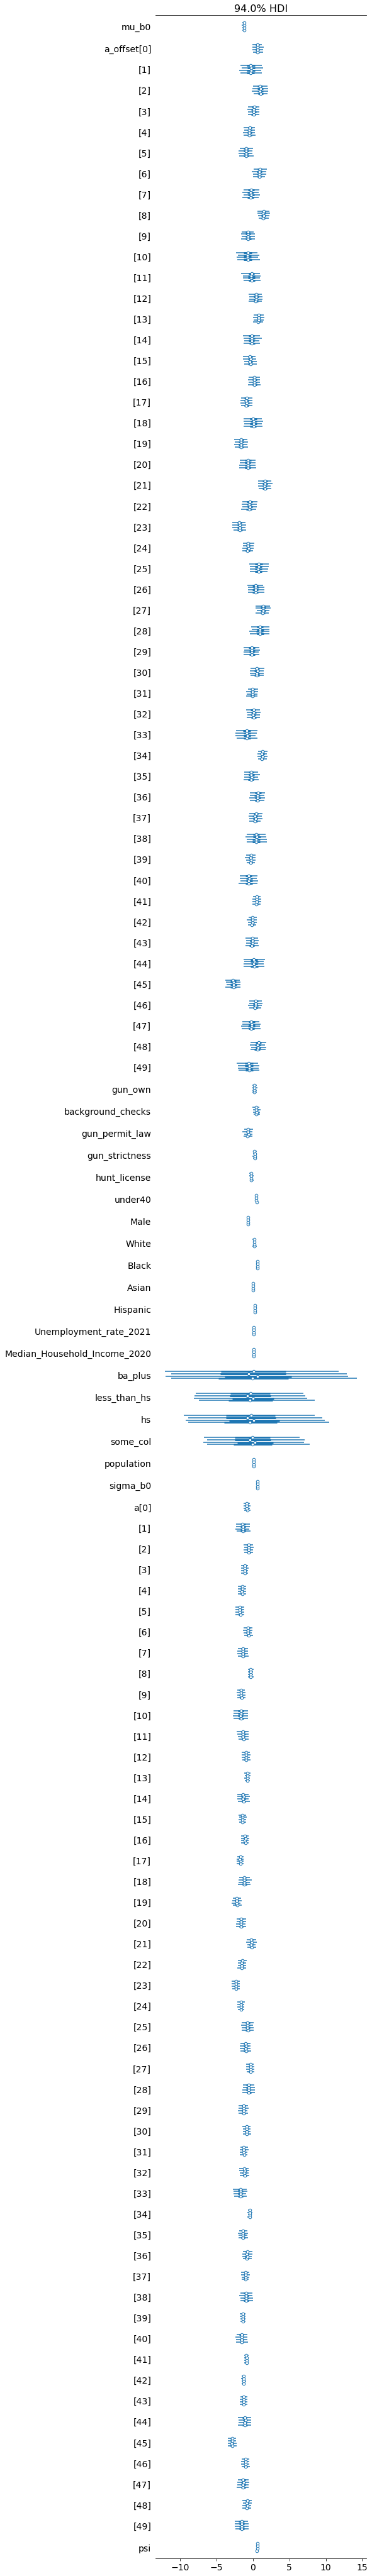

In [139]:
az.plot_forest(h4_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

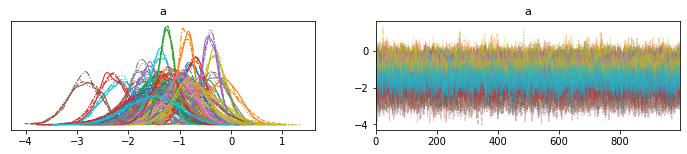

In [145]:
az.plot_trace(h4_trace,var_names=('^a$'), filter_vars="regex") # Here is a plot of Beta for the heirarchical intercept of the 50 states in our regression model

In [136]:
tmp = data[['state_r', 'STATE']].drop_duplicates().reset_index()

out_tbl = st_tbl['mean'].reset_index()
out_tbl['STATE'] = tmp['STATE']
out_tbl['state_r'] = tmp['state_r']
out_tbl.to_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/state_scores.csv')